# Fill in missing values for real-time yield curve
Date: 2024-12-05  
Last Editor: Gil   
Last Edit Date: 2025-09-09


This notebook was tested on Python 3.10 but should run on any newer version. To run this notebook, use the `requirements_jupyter.txt` found in the `train-minute-yield-curve` cloud function directory. Then, perform the following updates to the notebook:
1. Change `TARGET_DATE` to be the date with missing values for the real-time yield curve that will be filled in with this notebook
2. Put the location of the GCP credentials in `os.environ['GOOGLE_APPLICATION_CREDENTIALS']`
3. Set `UPLOAD_TO_BIGQUERY_AND_REDIS` to `True` to upload to BigQuery or Redis; by default, it is set to `False` to not write which is desirable during testing
4. (Optional) if testing frequently, consider setting the `save_data` optional argument in `load_pickled_query_results_if_exists(...)` to `True` to cache the results of the API call

In [14]:
%pip install finnhub-python

Note: you may need to restart the kernel to use updated packages.


In [15]:
import os
import time
import requests
import pickle
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt
#from tqdm.notebook import tqdm

import auxiliary_variables
auxiliary_variables.TESTING = True    # this allows print statements to be used throughout the files; since auxiliary_variables.TESTING has already been updated, subsequent imports will reflect this change, since Python modules are cached after the first import, so the change remains effective

from auxiliary_variables import PROJECT_ID, DATASET_NAME, ALPHA, DAILY_ETF_WEIGHTS_TABLES, ETFs
from auxiliary_functions import previous_business_day
from bigquery_utils import load_daily_etf_prices_bq, load_maturity_bq, load_index_yields_bq, get_scalar_df, load_shape_parameter,load_scaler_daily_bq
from yieldcurve import get_maturity_dict, get_NL_inputs, scale_X, run_NL_ridge, get_coefficient_df, get_scaler_params
from main import YIELD_CURVE_REDIS_CLIENT, get_schema_minute_yield, load_etf_models_bq, get_prediction_for_sp_maturity_table, upload_data_to_bigquery, upload_data_to_redis

In [16]:
UPLOAD_TO_BIGQUERY_AND_REDIS = True

In [17]:
TARGET_DATE = '2025-09-09'    # date with missing values for the real-time yield curve
TARGET_YEAR_MONTH = pd.to_datetime(TARGET_DATE).strftime('%Y-%m')

In [18]:
YEAR_MONTH_DAY = '%Y-%m-%d'
HOUR_MIN = '%H:%M'
YEAR_MONTH_DAY_HOUR_MIN = f'{YEAR_MONTH_DAY}:{HOUR_MIN}'
YEAR_MONTH_DAY_HOUR_MIN_SEC = f'{YEAR_MONTH_DAY} %H:%M:%S'

In [19]:
ALPHA_VANTAGE_KEY = 'EZR0IHAAL6MFWX4B'    # TODO: where did we get this from?

In [20]:
def load_pickled_query_results_if_exists(file_name: str, url: str, api_call_function: callable, save_data: bool = False) -> pd.DataFrame:
    file_name = f'files/{file_name}'
    if os.path.exists(file_name):
        print(f'Found {file_name} so will try to load the pickle file')
        with open(file_name, 'rb') as f:
            saved_url, df = pickle.load(f)
        
        if saved_url == url:
            print(f'Saved URL matched the desired URL so will load the dataframe')
            return df
        else:
            print(f'Saved URL: {saved_url} does not match desired URL: {url}, so will make API call')
    
    df = api_call_function(url)
    if save_data:
        print(f'Saving the URL and dataframe in the pickle file: {file_name}')
        with open(file_name, 'wb') as f:
            pickle.dump((url, df), f)
    return df

In [21]:
def get_latest_etf_minute_prices_from_alpha_vantage(etf: str, year_month: str, wait: bool = False) -> pd.DataFrame:
    '''`wait` is a boolean that determines whether we wait to avoid hitting the upper limit of the API calls.'''
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={etf}&interval=1min&extended_hours=false&adjusted=false&month={year_month}&outputsize=full&apikey={ALPHA_VANTAGE_KEY}'
    print(f'Getting data for {etf} on {year_month} using: {url}')
    
    def api_call_function(url: str) -> pd.DataFrame:
        num_seconds_to_wait_between_api_calls = 15
        if wait:
            print(f'... waiting {num_seconds_to_wait_between_api_calls} seconds to not hit the upper limit of API calls ...')
            time.sleep(num_seconds_to_wait_between_api_calls)
        r = requests.get(url)
        data = r.json()
        df = pd.DataFrame(data['Time Series (1min)']).T    # 'Time Series (1min)' is the name of the time series data

        for col in df:
            df[col] = df[col].astype(float)

        # rename columns to match the column names that are used downstream
        df.index.rename('Date', inplace=True)
        df = df.rename({'1. open': 'Open',
                        '2. high': 'High',
                        '3. low': 'Low',
                        '4. close': 'Close',
                        '5. volume': 'Volume'},
                        axis=1)
        df.columns = df.columns + '_' + etf
        df.index = pd.to_datetime(df.index)
        return df
    
    pickle_file_name = f'{etf}_{year_month}.pkl'
    return load_pickled_query_results_if_exists(pickle_file_name, url, api_call_function)

In [22]:
def get_latest_etf_minute_prices_for_all_etfs(year_month: str) -> dict:
    return {etf: get_latest_etf_minute_prices_from_alpha_vantage(etf, year_month, wait=(idx != 0)) for idx, etf in enumerate(ETFs)}    # do not wait on the first call because no other calls have been made yet


def get_close_prices_for_date(date: str, etf_to_dataframe: dict, open_time: str = '09:30', close_time: str = '15:59') -> pd.DataFrame:
    '''The default values for `open_time` and `close_time` are the market open and market close times respectively.'''
    combined_df = pd.concat([df.filter(regex='Close', axis=1) for _, df in etf_to_dataframe.items()], axis=1)    # get close prices for each ETF and merge into one dataframe
    combined_df.columns = combined_df.columns.str.replace('Close_', '', regex=False)    # remove the 'Close_' prefix from each column name
    
    get_open = lambda date: datetime.strptime(f'{date} {open_time}:00', YEAR_MONTH_DAY_HOUR_MIN_SEC)
    get_close = lambda date: datetime.strptime(f'{date} {close_time}:00', YEAR_MONTH_DAY_HOUR_MIN_SEC)
    complete_index = pd.date_range(start=get_open(date), end=get_close(date), freq='min')
    
    combined_df = combined_df.loc[date].reindex(complete_index).ffill()    # forward fill because Alpha Vantage prices have some gaps
    return combined_df


def is_valid_date_format(date_string: str):
    '''
    >>> is_valid_date_format('2025-01-13')
    True
    >>> is_valid_date_format('13-01-2025')
    False
    >>> is_valid_date_format('2025/01/13')
    False
    '''
    try:
        # Try to parse the string using the YYYY-MM-DD format
        datetime.strptime(date_string, YEAR_MONTH_DAY)
        return True
    except ValueError:
        # If parsing fails, the format is incorrect
        return False

In [23]:
# etf_to_dataframe = get_latest_etf_minute_prices_for_all_etfs(TARGET_YEAR_MONTH)
# combined_df_with_etf_quotes = get_close_prices_for_date(TARGET_DATE, etf_to_dataframe)

 # Add this to your imports at the top
import requests
from datetime import datetime
import pytz

# Use your existing FINNHUB_API_KEY from main.py
FINNHUB_API_KEY = 'c516kliad3if5950qksg'  # Your API key from main.py

def get_etf_minute_data_from_finnhub(etf: str, target_date: str, end_time: str = '15:59') -> pd.DataFrame:
    """Get minute data from Finnhub for a specific ETF and date"""
    
    # Convert to timestamps
    et = pytz.timezone('US/Eastern')
    start_dt = et.localize(datetime.strptime(f"{target_date} 09:30:00", "%Y-%m-%d %H:%M:%S"))
    end_dt = et.localize(datetime.strptime(f"{target_date} {end_time}:00", "%Y-%m-%d %H:%M:%S"))
    
    start_timestamp = int(start_dt.timestamp())
    end_timestamp = int(end_dt.timestamp())
    
    # Call Finnhub API
    url = f'https://finnhub.io/api/v1/stock/candle?symbol={etf}&resolution=1&from={start_timestamp}&to={end_timestamp}&token={FINNHUB_API_KEY}'
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if data.get('s') != 'ok' or not data.get('t'):
            print(f"No data for {etf}: {data}")
            return pd.DataFrame()
        
        # Create DataFrame
        df = pd.DataFrame({
            'timestamp': data['t'],
            'Open': data['o'],
            'High': data['h'],
            'Low': data['l'],
            'Close': data['c'],
            'Volume': data['v']
        })
        
        # Convert timestamps to datetime
        df['Date'] = pd.to_datetime(df['timestamp'], unit='s', utc=True).dt.tz_convert(et)
        df = df.set_index('Date').drop('timestamp', axis=1)
        
        # Add ETF suffix to column names
        df.columns = [f'{col}_{etf}' for col in df.columns]
        
        print(f"Got {len(df)} data points for {etf}")
        return df
        
    except Exception as e:
        print(f"Error getting data for {etf}: {e}")
        return pd.DataFrame()

def get_all_etfs_from_finnhub(target_date: str) -> dict:
    """Get minute data for all ETFs using Finnhub"""
    etf_data = {}
    
    for idx, etf in enumerate(ETFs):
        if idx > 0:
            # Finnhub rate limit depends on your plan
            # Free: 60 calls/min, Paid plans have higher limits
            time.sleep(1)  # Adjust based on your plan
        
        print(f"Processing {etf} ({idx+1}/{len(ETFs)})...")
        df = get_etf_minute_data_from_finnhub(etf, target_date)
        etf_data[etf] = df
    
    return etf_data

def combine_finnhub_data(etf_data: dict) -> pd.DataFrame:
    """Combine all ETF data into a single DataFrame with close prices"""
    close_dfs = []
    
    for etf, df in etf_data.items():
        if not df.empty and f'Close_{etf}' in df.columns:
            close_dfs.append(df[[f'Close_{etf}']])
    
    if not close_dfs:
        return pd.DataFrame()
    
    # Combine all close prices
    combined_df = pd.concat(close_dfs, axis=1)
    
    # Remove the 'Close_' prefix to match expected format
    combined_df.columns = combined_df.columns.str.replace('Close_', '', regex=False)
    
    # Forward fill any gaps
    combined_df = combined_df.ffill()
    
    return combined_df

# REPLACE YOUR TWO LINES WITH THESE:
print(f"Getting minute data from Finnhub for {TARGET_DATE}...")
etf_to_dataframe = get_all_etfs_from_finnhub(TARGET_DATE)

# Combine the data
combined_df_with_etf_quotes = combine_finnhub_data(etf_to_dataframe)

print(f"\nData shape: {combined_df_with_etf_quotes.shape}")
print(f"Time range: {combined_df_with_etf_quotes.index.min()} to {combined_df_with_etf_quotes.index.max()}")
print(combined_df_with_etf_quotes.head())

Getting minute data from Finnhub for 2025-09-09...
Processing MUB (1/11)...
Got 387 data points for MUB
Processing HYMB (2/11)...
Got 266 data points for HYMB
Processing TFI (3/11)...
Got 256 data points for TFI
Processing PZA (4/11)...
Got 250 data points for PZA
Processing SHM (5/11)...
Got 128 data points for SHM
Processing ITM (6/11)...
Got 205 data points for ITM
Processing SHYD (7/11)...
Got 41 data points for SHYD
Processing SUB (8/11)...
Got 285 data points for SUB
Processing FMHI (9/11)...
Got 56 data points for FMHI
Processing HYD (10/11)...
Got 316 data points for HYD
Processing MLN (11/11)...
Got 206 data points for MLN

Data shape: (390, 11)
Time range: 2025-09-09 09:30:00-04:00 to 2025-09-09 15:59:00-04:00
                                MUB     HYMB     TFI     PZA     SHM     ITM  \
Date                                                                           
2025-09-09 09:30:00-04:00  105.8055  24.7155  45.221  22.785  48.401  46.211   
2025-09-09 09:31:00-04:00  105

In [24]:
combined_df_with_etf_quotes

,MUB,HYMB,TFI,PZA,SHM,ITM,SHYD,SUB,FMHI,HYD,MLN
Date,,,,,,,,,,,
2025-09-09 09:30:00-04:00,105.8055,24.7155,45.221,22.785,48.4010,46.211,22.921,107.1910,47.203,50.3955,17.1955
2025-09-09 09:31:00-04:00,105.8255,24.6955,45.221,22.765,48.4010,46.211,22.921,107.1910,47.203,50.3955,17.2055
2025-09-09 09:32:00-04:00,105.8855,24.6955,45.221,22.795,48.3410,46.211,22.921,107.1910,47.203,50.4177,17.2055
2025-09-09 09:33:00-04:00,105.9455,24.7255,45.221,22.820,48.3410,46.211,22.921,107.2410,47.203,50.4255,17.2255
2025-09-09 09:34:00-04:00,105.9455,24.7255,45.221,22.820,48.3410,46.211,22.921,107.2410,47.203,50.4205,17.2255
...,...,...,...,...,...,...,...,...,...,...,...
2025-09-09 15:55:00-04:00,105.6705,24.6855,45.206,22.780,48.3573,46.236,22.886,107.0799,47.193,50.4105,17.1955
2025-09-09 15:56:00-04:00,105.7055,24.6905,45.211,22.780,48.3560,46.236,22.886,107.0810,47.193,50.4155,17.2005
2025-09-09 15:57:00-04:00,105.7055,24.6905,45.211,22.780,48.3560,46.241,22.886,107.0910,47.196,50.4155,17.2005


The below cell requires the `matplotlib` package.

In [25]:
def plot_change_in_etf_throughout_day(combined_df_with_etf_quotes: pd.DataFrame) -> None:
    for etf_idx, etf in enumerate(combined_df_with_etf_quotes.columns):
        plt.figure(figsize=(4, 3))
        combined_df_with_etf_quotes.iloc[:, etf_idx].plot()
        plt.title(etf)
        plt.xlabel('time')
        plt.ylabel('Value')
        plt.grid(True)
        plt.show()

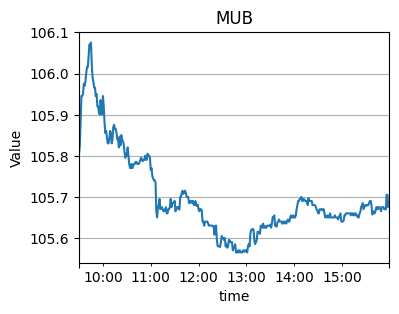

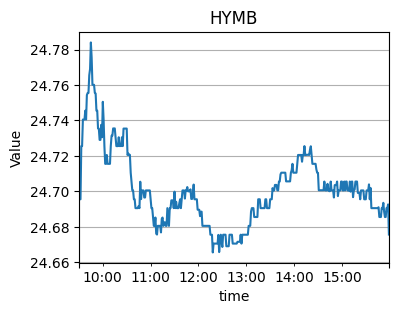

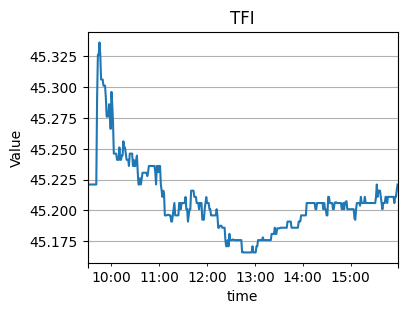

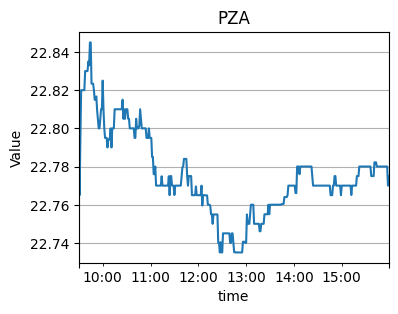

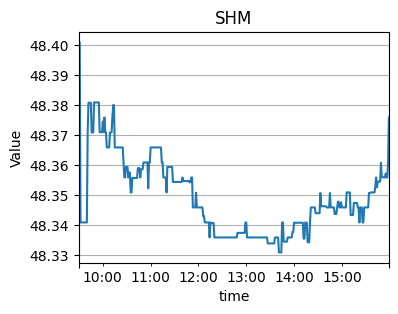

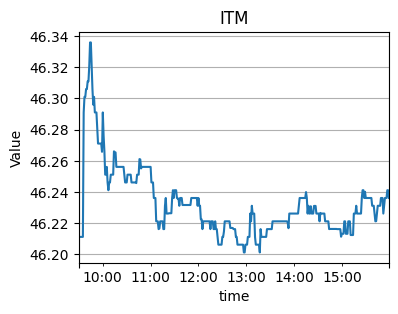

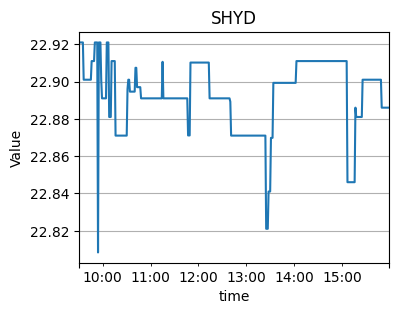

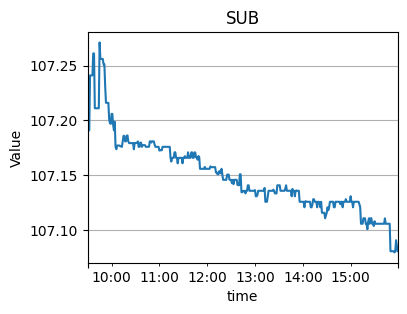

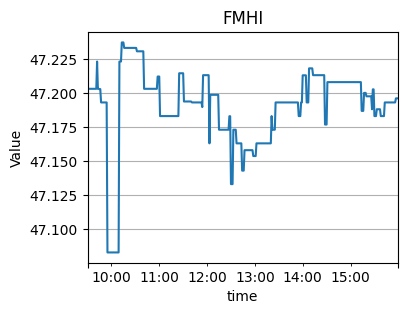

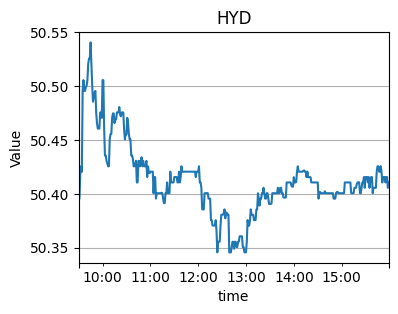

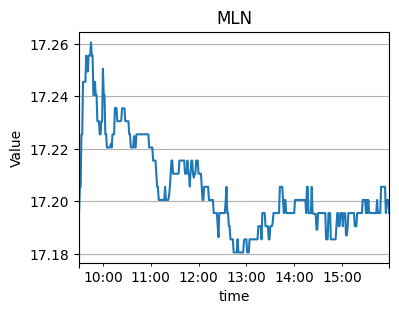

In [26]:
plot_change_in_etf_throughout_day(combined_df_with_etf_quotes)

Set credentials below to access BigQuery.

In [27]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/gil/git/ficc/creds.json'

Load BigQuery data. Taken almost directly from `cloud_functions/train-minute-yield-curve/main.py::main(...)`.

In [28]:
etf_data = load_daily_etf_prices_bq()
maturity_df = load_maturity_bq()
scaler_daily_parameters = load_scaler_daily_bq()
index_data = load_index_yields_bq()
etf_model_data = load_etf_models_bq()

Get scalar and maturity data most recent to `TARGET_DATE`. Taken almost directly from `cloud_functions/train-minute-yield-curve/main.py::main(...)`. Only put in values that are missing.

In [29]:
def get_timestamps_with_missing_yield_curve_values(date: str) -> list[str]:
    '''The returned list will have strings of the form: HH:MM.'''
    assert is_valid_date_format(date), f'{date} is not a valid YYYY-MM-DD format'
    market_end_time = datetime.strptime('15:59', HOUR_MIN)

    timestamps = []
    current_time = datetime.strptime('09:30', HOUR_MIN)    # initialize with market start time
    while current_time <= market_end_time:
        timestamps.append(current_time.strftime(HOUR_MIN))
        current_time += timedelta(minutes=1)

    timestamps = [f'{date}:{timestamp}' for timestamp in timestamps]    # put `date` before the timestamp and seconds after timestamp to be a valid redis key
    yield_curve_values = YIELD_CURVE_REDIS_CLIENT.mget(timestamps)
    return [timestamp for (timestamp, yield_curve_value) in zip(timestamps, yield_curve_values) if yield_curve_value is None]

In [30]:
timestamps_with_missing_yield_curve_values = get_timestamps_with_missing_yield_curve_values(TARGET_DATE)
print(timestamps_with_missing_yield_curve_values)
timestamps_with_missing_yield_curve_values = set(timestamps_with_missing_yield_curve_values)

['2025-09-09:09:30', '2025-09-09:09:31', '2025-09-09:09:32', '2025-09-09:09:33', '2025-09-09:09:34', '2025-09-09:09:35', '2025-09-09:09:36', '2025-09-09:09:37', '2025-09-09:09:38', '2025-09-09:09:39', '2025-09-09:09:40', '2025-09-09:09:41', '2025-09-09:09:42', '2025-09-09:09:43', '2025-09-09:09:44', '2025-09-09:09:45', '2025-09-09:09:46', '2025-09-09:09:47', '2025-09-09:09:48', '2025-09-09:09:49', '2025-09-09:09:50', '2025-09-09:09:51', '2025-09-09:09:52', '2025-09-09:09:53', '2025-09-09:09:54', '2025-09-09:09:55', '2025-09-09:09:56', '2025-09-09:09:57', '2025-09-09:09:58', '2025-09-09:09:59', '2025-09-09:10:00', '2025-09-09:10:01', '2025-09-09:10:02', '2025-09-09:10:03', '2025-09-09:10:04', '2025-09-09:10:05', '2025-09-09:10:06', '2025-09-09:10:07', '2025-09-09:10:08', '2025-09-09:10:09', '2025-09-09:10:10', '2025-09-09:10:11', '2025-09-09:10:12', '2025-09-09:10:13', '2025-09-09:10:14', '2025-09-09:10:15', '2025-09-09:10:16', '2025-09-09:10:17', '2025-09-09:10:18', '2025-09-09:10:19',

In [31]:
day_before_target_date = previous_business_day(TARGET_DATE, return_as_string=True)
exponential_mean, exponential_std, laguerre_mean, laguerre_std = get_scaler_params(day_before_target_date, scaler_daily_parameters)
maturity_dict = get_maturity_dict(maturity_df, day_before_target_date)

prev_close_data = [etf_data[fund][f'Close_{fund}'].loc[day_before_target_date:] for fund in ETFs]
prev_close_data = pd.concat(prev_close_data, axis=1)

yield_curve_coefficients_for_each_timestamp = []
tau = load_shape_parameter(day_before_target_date)
scalar_df = get_scalar_df(day_before_target_date)

In [32]:
for timestamp_to_the_minute, quote_data in combined_df_with_etf_quotes.iterrows():
    print(f"Processing {timestamp_to_the_minute}...") 
    intraday_change = ((quote_data.values - prev_close_data) / prev_close_data) * 100 * 100    # first 100 is for percent, and second 100 is for basis points
    
    predicted_ytw = pd.DataFrame()
    for daily_etf_weights_table_name in DAILY_ETF_WEIGHTS_TABLES:
        predicted_ytw[daily_etf_weights_table_name] = get_prediction_for_sp_maturity_table(daily_etf_weights_table_name, 
                                                                                           timestamp_to_the_minute, 
                                                                                           day_before_target_date, 
                                                                                           intraday_change, 
                                                                                           etf_model_data[daily_etf_weights_table_name], 
                                                                                           index_data[daily_etf_weights_table_name], 
                                                                                           verbose=False)

    yield_curve_df = predicted_ytw.T.rename({0: 'ytw'}, axis=1)
    yield_curve_df['Weighted_Maturity'] = yield_curve_df.index.map(maturity_dict).astype(float)
    X, y = get_NL_inputs(yield_curve_df, tau)
    X = scale_X(X, exponential_mean, exponential_std, laguerre_mean, laguerre_std)
    ridge_model = run_NL_ridge(X, y, scale=False, alpha=ALPHA)
    coefficient_df = get_coefficient_df(ridge_model, timestamp_to_the_minute)
    yield_curve_coefficients_for_each_timestamp.append(coefficient_df)
    
    if timestamp_to_the_minute.strftime(YEAR_MONTH_DAY_HOUR_MIN) in timestamps_with_missing_yield_curve_values:    # only perform upload if the timestamp is missing
        if UPLOAD_TO_BIGQUERY_AND_REDIS:
            print(f'{timestamp_to_the_minute} uploaded to BigQuery and Redis since `UPLOAD_TO_BIGQUERY_AND_REDIS` is set to `True`')
            upload_data_to_bigquery(coefficient_df, f'{PROJECT_ID}.{DATASET_NAME}.nelson_siegel_coef_minute', get_schema_minute_yield())
            upload_data_to_redis(timestamp_to_the_minute, coefficient_df, scalar_df, tau)
        else:
            print(f'{timestamp_to_the_minute} is missing and would be uploaded to BigQuery and Redis if `UPLOAD_TO_BIGQUERY_AND_REDIS` were set to `True`')

Processing 2025-09-09 09:30:00-04:00...
2025-09-09 09:30:00-04:00 uploaded to BigQuery and Redis since `UPLOAD_TO_BIGQUERY_AND_REDIS` is set to `True`
Upload to eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_minute successful
Upload to redis on host 127.0.0.1 successful. Key: 2025-09-09:09:30. Value: {'nelson_values':                                 const  exponential   laguerre
date                                                         
2025-09-09 09:30:00-04:00  314.257893   -60.895726 -34.485785, 'scalar_values': exponential_mean    0.409077
exponential_std     0.207093
laguerre_mean       0.234376
laguerre_std        0.055870
Name: 2025-09-08 00:00:00, dtype: float64, 'shape_parameter': 3.0}
Processing 2025-09-09 09:31:00-04:00...
2025-09-09 09:31:00-04:00 uploaded to BigQuery and Redis since `UPLOAD_TO_BIGQUERY_AND_REDIS` is set to `True`
Upload to eng-reactor-287421.yield_curves_v2.nelson_siegel_coef_minute successful
Upload to redis on host 127.0.0.1 successful. Key: 20

In [ ]:
pd.concat(yield_curve_coefficients_for_each_timestamp)

In [11]:
from main import YIELD_CURVE_REDIS_CLIENT, get_schema_minute_yield, load_etf_models_bq, get_prediction_for_sp_maturity_table, upload_data_to_bigquery, upload_data_to_redis
YIELD_CURVE_REDIS_CLIENT.get('2025-09-09 03:59')

In [12]:
count =0
for key in YIELD_CURVE_REDIS_CLIENT.scan_iter(match="*"):
    print(f"  {key}")
    count += 1
    if count >= 10:
        break

  b'2024-09-18:10:47'
  b'2021-12-13:11:08'
  b'2024-01-11:14:15'
  b'2023-10-09:13:44'
  b'2022-10-05:13:17'
  b'2024-04-03:11:55'
  b'2024-09-06:14:13'
  b'2024-01-26:14:47'
  b'2023-02-10:11:24'
  b'2022-09-19:13:15'


In [33]:
from datetime import datetime, timedelta

# Generate all the keys we want to delete
start = datetime.strptime("2025-09-09 16:00", "%Y-%m-%d %H:%M")
end = datetime.strptime("2025-09-09 16:00", "%Y-%m-%d %H:%M")

keys_to_delete = []
current = start
while current <= end:
    key = current.strftime("%Y-%m-%d:%H:%M")
    keys_to_delete.append(key)
    current += timedelta(minutes=1)

print(f"Will delete {len(keys_to_delete)} keys from {keys_to_delete[0]} to {keys_to_delete[-1]}")

# Delete them all at once using pipeline for speed
pipeline = YIELD_CURVE_REDIS_CLIENT.pipeline()
for key in keys_to_delete:
    pipeline.delete(key)

# Execute all deletes in one go
results = pipeline.execute()
deleted_count = sum(results)  # Each delete returns 1 if key existed, 0 if not

print(f"Deleted {deleted_count} keys out of {len(keys_to_delete)} attempted")

Will delete 1 keys from 2025-09-09:16:00 to 2025-09-09:16:00
Deleted 1 keys out of 1 attempted
